This code generates **Figure 7**

In [ ]:
import torch
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import scipy as sc
from matplotlib import pyplot as plt
import torch.nn as nn

In [ ]:
# !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla P100-PCIE-16GB, 460.32.03, 16280 MiB


In [ ]:
min_batch_size = 30
 #transforms.Normalize((0.1307,), (0.3081,))
transform = transforms.Compose(
    [transforms.ToTensor()])
train_dataset = torchvision.datasets.CIFAR10(root='CIFAR', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=min_batch_size,
                                          shuffle=True, num_workers=1)


Extracting CIFAR/cifar-10-python.tar.gz to CIFAR


In [ ]:
dtype = torch.cuda.FloatTensor
dtype_labels = torch.cuda.LongTensor

In [ ]:
import torch.nn as nn
class AlexNet(torch.nn.Module):
    def __init__(self, output_dim,num_layers = 0,level = 3, withbn = False):
        super().__init__()
        filters = [64, 192 , 385, 256, 256 ]
        layers = []
        layers += [nn.Conv2d(3, 64, 3, 2, 1)] #in_channels, out_channels, kernel_size, stride, padding
        layers += [nn.MaxPool2d(2)] #kernel_size
        layers += [nn.ReLU(inplace = True)]
        layers += [nn.Conv2d(64, 192, 3, padding = 1)]
        layers += [nn.MaxPool2d(2)]
        layers += [nn.ReLU(inplace = True)]
        # -----------
        layers += [nn.Conv2d(192, 192, 3, padding = 1)]
        layers += [nn.ReLU(inplace = True)]
        if level == 2: 
          for i in range(num_layers):
            layers += [nn.Conv2d(192, 192, 3, padding = 1,bias=False),nn.ReLU(inplace=True)]
            if withbn:
              layers += [nn.BatchNorm2d(192)]
        # ------------
        layers += [nn.Conv2d(192, 256, 3, padding = 1)]
        layers += [nn.Conv2d(256, 256, 3, padding = 1),nn.ReLU(inplace=True)]
        if level == 3: 
          for i in range(num_layers):
            layers += [nn.Conv2d(256, 256, 3, padding = 1),nn.ReLU(inplace=True)]
            if withbn:
              layers += [nn.BatchNorm2d(256)]
            
        layers += [nn.MaxPool2d(2)]
        layers += [nn.ReLU(inplace = True)]
        self.features = nn.Sequential(*layers)
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 4*1024),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4*1024, 4*1024),
            nn.ReLU(inplace = True),
            nn.Linear(4*1024, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x
    def forward_noclassi(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        return h
def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight,gain=torch.nn.init.calculate_gain('relu'))
        if m.bias is not None:
            m.bias.data.fill_(0)
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight,gain=torch.nn.init.calculate_gain('relu'))
        if m.bias is not None:
            m.bias.data.fill_(0)

In [ ]:
def train(net,epoch_num = 10,stepsize = 0.01):
    criterion = nn.CrossEntropyLoss(size_average=True)
    opt= torch.optim.SGD(net.parameters(), lr=stepsize)
    output = []
    num_total = len(train_dataset.targets) 
    for j in range(epoch_num):
        loss_epoch = 0
        for i, data in enumerate(train_loader): 
            x, y = data
            x = x.type(dtype)
            y = y.type(dtype_labels)
            
            opt.zero_grad()
            outx = net.forward(x)
            loss = criterion(outx, y)
            loss.backward()
            loss_epoch += loss.item()*min_batch_size/num_total
            # if i % 1000 ==0:
            #     print(i)
            opt.step()
        print(loss_epoch)
        output.append(loss_epoch)
    return output
    

The following function extend the svd based initialization to convolutional networks. When samples are pass throught the network layers. We use SVD decomposition of hidden representations to recurrently initialize the weights through the layers.   

In [ ]:
def novel_initialization(anet_im): # the input is a network 
  # picks a batch of samples
  bs = 256
  train_loader2 = torch.utils.data.DataLoader(train_dataset, batch_size=bs,
                                            shuffle=True, num_workers=1)
  dataiter = iter(train_loader2)
  images, labels = dataiter.next()
  images = images.type(dtype)
  out = anet_im.forward_noclassi(images)
  M = out.t().mm(out)
  print(torch.norm(M)/torch.trace(M))
  x = images
  steps = 1200
  for unit in anet_im.features:
    if isinstance(unit,nn.Conv2d): 
      if unit.in_channels == unit.out_channels: 
          zp = torch.nn.ZeroPad2d(unit.padding[0])
          input = x.data
          print(input.size())
          input = zp(input)
          w = unit.weight
          d2 = input.size(2)
          d3 = input.size(3)
          ### here we reshape representations to implemnet the convolution using matrix multiplication 
          inp_unf = torch.nn.functional.unfold(input,kernel_size=unit.kernel_size,stride=unit.stride)
          inp_unf_size = inp_unf.size()
          inp_unf = inp_unf.transpose(1,2)
          inp_unf = inp_unf.reshape(inp_unf.size(0)*inp_unf.size(1),inp_unf.size(2))
          ### svd decomposition of the reshaped representations 
          u,s,v = torch.svd(inp_unf) 
          wd = w.view(w.size(0), -1).t().size(1)
          w1 = u[0:wd,0:wd].mm(torch.diag(1/torch.pow(s[0:wd],0.5))).mm(v.t()[0:wd,:])
          unit.weight.data = w1.reshape(w.size())
          unit.weight.data = unit.weight.data/torch.norm(unit.forward(x))
          print(torch.norm(unit.weight.data))
    x = unit(x)
    H = x.flatten(1)
    M = H.mm(H.t())
    # print(torch.norm(M)/torch.trace(M))
    # print('=======')
  out = anet_im.forward_noclassi(images)
  M = out.t().mm(out)
  print(torch.norm(M)/torch.trace(M))
  return anet_im

In [1]:
layers = [15,75]
epochs = 20
repeat = 4
lr = 0.001

results_xavier = []
results_novel = []
for i in range(repeat):
  result_xavier = []
  result_novel = []
  for layer in layers: 
    print(layer,'============')
    anet = AlexNet(10,num_layers=layer,withbn = False)
    anet = anet.cuda()
    anet = anet.apply(weights_init)
    conv = train(anet,epoch_num=epochs,stepsize=lr)
    result_xavier.append(conv)
    anet_novel = AlexNet(10,num_layers=layer,withbn=False)
    anet_novel = anet_novel.cuda()
    anet_novel.apply(weights_init)
    anet_novel = novel_initialization(anet_novel)
    conv_novel = train(anet_novel,epoch_num=epochs,stepsize=lr)
    result_novel.append(conv_novel)
  results_novel.append(result_novel)
  results_xavier.append(result_xavier)


In [ ]:
# np.save('novelinit_conv',[results_novel,results_xavier])
# files.download('novelinit_conv.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import seaborn as sns

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

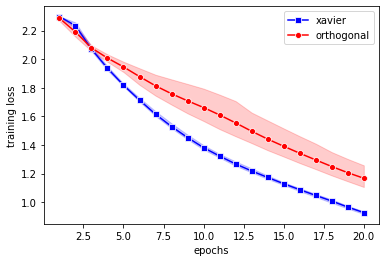

In [ ]:
result_array_novel = np.asarray(results_novel)
result_array_xav = np.asarray(results_xavier)
results_plot=[]
D = []
for i in range(repeat): 
    run_dict={'run_id': np.ones(epochs,dtype=np.int8)*i,'training loss novel':result_array_novel[i][0],'training loss':result_array_xav[i][0]}

    for j in range(epochs): 
        D.append(j+1)
    results_plot.append(pd.DataFrame(run_dict))
    
results_plot=pd.concat(results_plot)

p2 = sns.lineplot(data=results_plot,x=D,y="training loss",  marker='s',ci=95,color='blue',label='xavier')
p1 = sns.lineplot(data=results_plot,x=D,y="training loss novel",  marker = 'o', ci=95,color='red',label='orthogonal')

# ax2 = plt.twinx()
# p2 = sns.lineplot(data=results_plot,x=D,y="training loss",  marker='s',ci=95,color='blue',ax = ax2)
p2.set(xlabel='epochs')
fig = p2.get_figure()
fig.savefig('convolutional_15.pdf',format='pdf')
files.download('convolutional_15.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

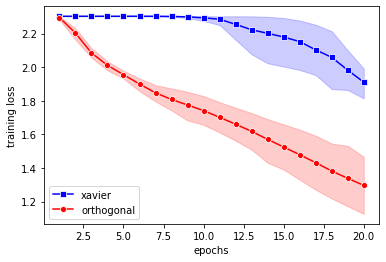

In [ ]:
results_plot=[]
D = []
for i in range(repeat): 
    run_dict={'run_id': np.ones(epochs,dtype=np.int8)*i,'training loss novel':result_array_novel[i][1],'training loss':result_array_xav[i][1]}

    for j in range(epochs): 
        D.append(j+1)
    results_plot.append(pd.DataFrame(run_dict))
    
results_plot=pd.concat(results_plot)

p2 = sns.lineplot(data=results_plot,x=D,y="training loss",  marker='s',ci=95,color='blue',label='xavier')
p1 = sns.lineplot(data=results_plot,x=D,y="training loss novel",  marker = 'o', ci=95,color='red',label='orthogonal')

# ax2 = plt.twinx()
# p2 = sns.lineplot(data=results_plot,x=D,y="training loss",  marker='s',ci=95,color='blue',ax = ax2)
p2.set(xlabel='epochs')
fig = p2.get_figure()
fig.savefig('convolutional_75.pdf',format='pdf')
files.download('convolutional_75.pdf')